In [1]:
#i want to test energy falloff rates for various resolutions and viscosities


In [2]:
#conservation or lack thereof were hard to demonstrate here...

In [3]:
#def xop2_2d(g, f, a0, a):
from tqdm import tqdm
from tools.operators_single_overlap import xop_2d, yop_2d, Discrete1DGrid, RHSswe, RK3
from tools.plotting import VisualizeGrid, coLocateVelocity, StartPlot, UpdatePlot
from tools.plotting import StartPlotEnergy, UpdatePlotEnergy
from tools.tests import StabilityCheck, calc_diagnostics
import numpy as np
from matplotlib import pyplot as plt
import time

### Soliton Domain
-24 <= x <= 24, -8 <= y <= 8 <br>
Coriolis: f = y <br>
depth: H = 1 <br>
gravity: g = 1 <br>
tfinal: 40

Stable timestep for coarsest resolution is dt = 0.02 (explain)

Use symmetry to update vorticity variables?

#### First Geometry - 80km resolution

In [4]:
xmin,xmax,N = -24, 24, 96*4
ymin,ymax,M = -8, 8, 32*4

# discretize x-y directions on a C-grid
xe,xc,dx = Discrete1DGrid(xmin,xmax,N)
ye,yc,dy = Discrete1DGrid(ymin,ymax,M)
xp,yp = np.meshgrid(xc,yc) # p-points
xu,yu = np.meshgrid(xe,yc) # u-points
xv,yv = np.meshgrid(xc,ye) # v-points
xz,yz = np.meshgrid(xe,ye) # z-points (vorticity)
dxs = np.array([dx,dy])    # grid size
# VisualizeGrid(xu,yu,xv,yv,xp,yp,xz,yz) # visualize grid optional

gravity = 1
depth = np.ones([M,N])
coriolis = yz.copy()

In [5]:
def initialize_soliton(xu,yu,xv,yv,xp,yp,xz,yz,dxs,B=0.395):
    phiu = 0.771 * B**2 * ( 1/np.cosh(B*xu)**2) 
    phiv = 0.771 * B**2 * ( 1/np.cosh(B*xv)**2) 
    phip = 0.771 * B**2 * ( 1/np.cosh(B*xp)**2)
    
    
#     dphi_dxu = -2 * phiu * B * np.tanh(B*xu) #dont need maybe
    dphi_dxv = -2 * phiv * B * np.tanh(B*xv)
    
    
    u = (6*yu**2 - 9)/4 * phiu * np.exp(-(yu**2/2))
    v = 2*yv*(dphi_dxv)*np.exp(-(yv**2/2))
    p = (6*yp**2 + 3)/4 * phip * np.exp(-(yp**2/2))
    
    return u,v,p
    

In [6]:
%matplotlib

Using matplotlib backend: <object object at 0x0000022BF09AA540>


In [7]:
plt.close('all')

### initial conditions


In [8]:
u,v,p = initialize_soliton(xu,yu,xv,yv,xp,yp,xz,yz,dxs,B=0.395)
# #wrap edges - u-points have two overlaps
# u[:, 0] =  u[:, -2]  # Wrap west to east
# u[:, -1] = u[:, 1]  # Wrap east to west

# # v, p-points have one overlap
# v[:, -1] = v[:, 0]  # Wrap east to west
# p[:, -1] = p[:, 0]  # Wrap east to west

In [9]:
periodic = True

alin = 1 # toggles between linear (0), nonlinear (1) PDEs
visc = .001
# tolerance = 10**-5
cell_area = dx*dy
ntimesteps = 6000
isnap = 10       # frequency of visualization
finaltime = 300
dt = finaltime/ntimesteps
StabilityCheck(gravity,depth,dt,dx)

max. Courant number: 0.4
Stable gravity wave time step:


In [10]:
#reset indices for diagnostic calculations depending on BCs
if periodic:
    ind1u,ind2u = 1,len(u[0,])
    ind1v,ind2v = 1,len(v[0,])
    ind1p,ind2p = 1,len(p[0,])
    ind1z,ind2z = 1,len(coriolis[0,])
else:
    ind1u, ind2u = 0, len(u[0,])
    ind1v ,ind2v = 0, len(v[0,])
    ind1p ,ind2p = 0, len(p[0,])
    ind1z ,ind2z = 0, len(coriolis[0,])

In [11]:
initial_energy, initial_enstrophy, initial_mass = calc_diagnostics(u[:,ind1u:ind2u],v[:,ind1v:ind2v],p[:,ind1p:ind2p],dxs,depth[:,ind1p:ind2p],gravity,coriolis[:,ind1z:ind2z],alin)

### ADJUST P LEVS FOR PRESSURE CONTOURS


In [12]:
#set pmin manually since it drops slightly from beginning
plevs=np.linspace(-0.25,p.max(),40)
xas,yas=8,8

In [13]:
fig,ax,pcont,arrows = StartPlot(u,v,p,xe,xc,ye,yc,plevs,XarrowStep=xas,YarrowStep=yas,arrow_scale=4 ,colormap='viridis')
plt.show()

In [14]:
total_system_energy = [initial_energy]
total_system_enstrophy = [initial_enstrophy]
total_system_mass = [initial_mass]
times = [0.0]


In [15]:
for it in tqdm(range(ntimesteps)):
    timeCurrent = it*dt
    RK3(u,v,p,depth, coriolis, gravity, dxs, dt, timeCurrent, visc,bdc=0,tau_x=0,tau_y=0, alin=1,periodic=periodic)
    if (it+1)%isnap==0:
        time.sleep(0.01)
        pcont = UpdatePlot(u,v,p,xe,xc,ye,yc,ax,pcont,plevs,timeCurrent+dt,arrows,XarrowStep=xas,YarrowStep=yas,colormap='viridis') # update numerical plot
        times.append(timeCurrent)
        eg, es, ms = calc_diagnostics(u[:,ind1u:ind2u],v[:,ind1v:ind2v],p[:,ind1p:ind2p],dxs,depth[:,ind1p:ind2p],gravity,coriolis[:,ind1z:ind2z],alin)
        total_system_energy.append(eg)
        total_system_enstrophy.append(es)
        total_system_mass.append(ms)

 31%|███       | 1869/6000 [00:43<01:35, 43.23it/s]


KeyboardInterrupt: 

In [16]:
plt.close('all')

In [17]:
%matplotlib inline

In [18]:
mass_plot = np.array(total_system_mass)/initial_mass
energy_plot = np.array(total_system_energy)/initial_energy
enstrophy_plot = (np.array(total_system_enstrophy) + 1.)/(initial_enstrophy+1.)

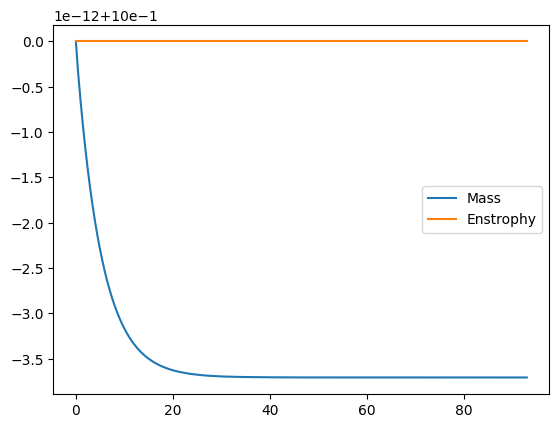

In [19]:
plt.plot(times,mass_plot, label='Mass')
# plt.plot(times,energy_plot, label='Energy')
plt.plot(times,enstrophy_plot, label='Enstrophy')
plt.legend()
plt.show()

In [20]:
total_system_mass

[49243.85375637837,
 49243.853756361656,
 49243.85375634648,
 49243.85375633269,
 49243.85375632017,
 49243.853756308796,
 49243.85375629846,
 49243.85375628907,
 49243.85375628053,
 49243.85375627278,
 49243.85375626574,
 49243.85375625935,
 49243.85375625353,
 49243.85375624825,
 49243.85375624346,
 49243.85375623911,
 49243.85375623514,
 49243.85375623155,
 49243.85375622828,
 49243.853756225304,
 49243.85375622261,
 49243.85375622017,
 49243.85375621794,
 49243.85375621591,
 49243.853756214085,
 49243.85375621241,
 49243.853756210905,
 49243.85375620952,
 49243.85375620828,
 49243.853756207136,
 49243.8537562061,
 49243.85375620518,
 49243.85375620432,
 49243.85375620355,
 49243.85375620284,
 49243.853756202196,
 49243.85375620162,
 49243.85375620109,
 49243.85375620062,
 49243.85375620017,
 49243.85375619978,
 49243.853756199416,
 49243.853756199096,
 49243.85375619879,
 49243.85375619854,
 49243.85375619828,
 49243.853756198056,
 49243.85375619785,
 49243.85375619767,
 49243.8537

### Does energy "converge" faster with higher viscosity???????

In [ ]:
# define geometry of domain - 3,600km x, 2,800 km y, with 20km resolution
xmin,xmax,N = 0.0,3600000.0, 45#90 #180
ymin,ymax,M = 0.0, 2800000.0,35  #70 #140

# discretize x-y directions on a C-grid
xe,xc,dx = Discrete1DGrid(xmin,xmax,N)
ye,yc,dy = Discrete1DGrid(ymin,ymax,M)
xp,yp = np.meshgrid(xc,yc) # p-points
xu,yu = np.meshgrid(xe,yc) # u-points
xv,yv = np.meshgrid(xc,ye) # v-points
xz,yz = np.meshgrid(xe,ye) # z-points (vorticity)
dxs = np.array([dx,dy])    # grid size
# VisualizeGrid(xu,yu,xv,yv,xp,yp,xz,yz) # visualize grid optional

gravity =2.2025*10**(-2)
depth = 1000*np.ones([M,N])
coriolis = np.zeros_like(xz) # coriolis parameter
coriolis+=0.00009 + yz * 1.8*10**-11 #mid-latitude B-plane

u,v,p = initialize_vortex(xu,xv,xp,yp,xz,yz,dxs[0],dxs[1],
                          gravity,
                         coriolis,
                         a=100,
                         L=200000,
                         x_center=1.8 * 10 ** 6,
                         y_center= 1.4 * 10 ** 6)

u1,v1,p1=initialize_vortex(xu,xv,xp,yp,xz,yz,dxs[0],dxs[1],
                          gravity,
                         coriolis,
                         a=50,
                         L=100000,
                         x_center=1.4 * 10 ** 6,
                         y_center=1.4 * 10 ** 6)

u += u1
v += v1
p += p1

In [ ]:
plevs = np.arange(-200, 200, 10)
fig,ax,pcont,arrows = StartPlot(u,v,p,xe,xc,ye,yc,plevs,XarrowStep=4,YarrowStep=4,arrow_scale=2)
plt.show()
total_system_energy = []
total_system_enstrophy = []
lapl_integral = []
times = [0.0]

In [ ]:
alin = 1 # toggles between linear (0), nonlinear (1) PDEs
visc = .99
tolerance = 10**-4
cell_area = dx*dy
ntimesteps = 25600*2
isnap = 20       # frequency of visualization
finaltime = 256000000
dt = finaltime/ntimesteps
StabilityCheck(gravity,depth,dt,dx)

total_system_energy.append(calculate_energy(u,v,p,depth,gravity))
total_system_enstrophy.append(calculate_enstrophy(u,v,p,dxs,depth,coriolis,alin))

fig2, ax2, pline,pline2 = StartPlotEnergy() 
# fig2,ax2,lline = StartPlotULaplace(u,dxs)

for it in tqdm(range(ntimesteps)):
    timeCurrent = it*dt
    RK3(u,v,p,depth, coriolis, gravity, dxs, dt, timeCurrent, visc, alin)


    
#         vort_grid[1:-1,1:-1] = x_vort - y_vort
#         pcont = UpdatePlotVort(vort_grid,xe,ye,ax,pcont,plevs,timeCurrent) # update numerical plot
        
    #p plot
    if (it+1)%isnap==0:
        pcont = UpdatePlot(u,v,p,xe,xc,ye,yc,ax,pcont,plevs,timeCurrent+dt,arrows,XarrowStep=4,YarrowStep=4) # update numerical plot
#         lline, TL, LI = UpdatePlotULaplace(ax2,lline,u,dxs)
#         lapl_integral.append(LI)

        times.append(timeCurrent)
        total_system_energy.append(calculate_energy(u,v,p,depth,gravity))
        total_system_enstrophy.append(calculate_enstrophy(u,v,p,dxs,depth,coriolis,alin))

        
        time_array = np.array(times)
        energy_array = np.array(total_system_energy)
        plotting_energy = energy_array/energy_array[0]
        
        if np.abs(plotting_energy[-1] - plotting_energy[-2]) < tolerance:
            print("Timesteps to reach Stable Energy: {}".format(it))
            print('Time elapsed: {}'.format(timeCurrent))
            break
        
        enstrophy_array = np.array(total_system_enstrophy)
        plotting_array_2 = enstrophy_array/enstrophy_array[0]
        
        pline, pline2 = UpdatePlotEnergy(ax2,pline,pline2,time_array,plotting_energy,plotting_array_2,timeCurrent)

In [ ]:
#viscosity not seeming to make a difference here...

#### Second Geometry - 40km resolution

In [ ]:
# define geometry of domain - 3,600km x, 2,800 km y, with 20km resolution
xmin,xmax,N = 0.0,3600000.0, 90 #180
ymin,ymax,M = 0.0, 2800000.0, 70 #140

# discretize x-y directions on a C-grid
xe,xc,dx = Discrete1DGrid(xmin,xmax,N)
ye,yc,dy = Discrete1DGrid(ymin,ymax,M)
xp,yp = np.meshgrid(xc,yc) # p-points
xu,yu = np.meshgrid(xe,yc) # u-points
xv,yv = np.meshgrid(xc,ye) # v-points
xz,yz = np.meshgrid(xe,ye) # z-points (vorticity)
dxs = np.array([dx,dy])    # grid size
# VisualizeGrid(xu,yu,xv,yv,xp,yp,xz,yz) # visualize grid optional

gravity =2.2025*10**(-2)
depth = 1000*np.ones([M,N])
coriolis = np.zeros_like(xz) # coriolis parameter
coriolis+=0.00009 + yz * 1.8*10**-11 #mid-latitude B-plane

In [ ]:
u,v,p = initialize_vortex(xu,xv,xp,yp,xz,yz,dxs[0],dxs[1],
                          gravity,
                         coriolis,
                         a=100,
                         L=200000,
                         x_center=1.8 * 10 ** 6,
                         y_center= 1.4 * 10 ** 6)

u1,v1,p1=initialize_vortex(xu,xv,xp,yp,xz,yz,dxs[0],dxs[1],
                          gravity,
                         coriolis,
                         a=50,
                         L=100000,
                         x_center=1.4 * 10 ** 6,
                         y_center=1.4 * 10 ** 6)

u += u1
v += v1
p += p1

In [ ]:
plevs = np.arange(-200, 200, 10)
fig,ax,pcont,arrows = StartPlot(u,v,p,xe,xc,ye,yc,plevs,XarrowStep=4,YarrowStep=4,arrow_scale=2)
# plt.show()

In [ ]:
total_system_energy = []
total_system_enstrophy = []
lapl_integral = []
times = [0.0]


In [ ]:
alin = 1 # toggles between linear (0), nonlinear (1) PDEs
visc = .01
tolerance = 10**-5
cell_area = dx*dy
ntimesteps = 256000
isnap = 20       # frequency of visualization
finaltime = 256000000
dt = finaltime/ntimesteps
StabilityCheck(gravity,depth,dt,dx)

total_system_energy.append(calculate_energy(u,v,p,depth,gravity))
total_system_enstrophy.append(calculate_enstrophy(u,v,p,dxs,depth,coriolis,alin))

fig2, ax2, pline,pline2 = StartPlotEnergy() 
# fig2,ax2,lline = StartPlotULaplace(u,dxs)

for it in tqdm(range(ntimesteps)):
    timeCurrent = it*dt
    RK3(u,v,p,depth, coriolis, gravity, dxs, dt, timeCurrent, visc, alin)


    
#         vort_grid[1:-1,1:-1] = x_vort - y_vort
#         pcont = UpdatePlotVort(vort_grid,xe,ye,ax,pcont,plevs,timeCurrent) # update numerical plot
        
    #p plot
    if (it+1)%isnap==0:
        pcont = UpdatePlot(u,v,p,xe,xc,ye,yc,ax,pcont,plevs,timeCurrent+dt,arrows,XarrowStep=4,YarrowStep=4) # update numerical plot
#         lline, TL, LI = UpdatePlotULaplace(ax2,lline,u,dxs)
#         lapl_integral.append(LI)

        times.append(timeCurrent)
        total_system_energy.append(calculate_energy(u,v,p,depth,gravity))
        total_system_enstrophy.append(calculate_enstrophy(u,v,p,dxs,depth,coriolis,alin))

        
        time_array = np.array(times)
        energy_array = np.array(total_system_energy)
        plotting_energy = energy_array/energy_array[0]
        
        if np.abs(plotting_energy[-1] - plotting_energy[-2]) < tolerance:
            print("Timesteps to reach Stable Energy: {}".format(it))
            print('Time elapsed: {}'.format(timeCurrent))
            break
        
        enstrophy_array = np.array(total_system_enstrophy)
        plotting_array_2 = enstrophy_array/enstrophy_array[0]
        
        pline, pline2 = UpdatePlotEnergy(ax2,pline,pline2,time_array,plotting_energy,plotting_array_2,timeCurrent)

In [ ]:
plt.close('all')

### Try adding viscosity

In [ ]:
# define geometry of domain - 3,600km x, 2,800 km y, with 20km resolution
xmin,xmax,N = 0.0,3600000.0, 90 #180
ymin,ymax,M = 0.0, 2800000.0, 70 #140

# discretize x-y directions on a C-grid
xe,xc,dx = Discrete1DGrid(xmin,xmax,N)
ye,yc,dy = Discrete1DGrid(ymin,ymax,M)
xp,yp = np.meshgrid(xc,yc) # p-points
xu,yu = np.meshgrid(xe,yc) # u-points
xv,yv = np.meshgrid(xc,ye) # v-points
xz,yz = np.meshgrid(xe,ye) # z-points (vorticity)
dxs = np.array([dx,dy])    # grid size
# VisualizeGrid(xu,yu,xv,yv,xp,yp,xz,yz) # visualize grid optional

gravity =2.2025*10**(-2)
depth = 1000*np.ones([M,N])
coriolis = np.zeros_like(xz) # coriolis parameter
coriolis+=0.00009 + yz * 1.8*10**-11 #mid-latitude B-plane

u,v,p = initialize_vortex(xu,xv,xp,yp,xz,yz,dxs[0],dxs[1],
                          gravity,
                         coriolis,
                         a=100,
                         L=200000,
                         x_center=1.8 * 10 ** 6,
                         y_center= 1.4 * 10 ** 6)

u1,v1,p1=initialize_vortex(xu,xv,xp,yp,xz,yz,dxs[0],dxs[1],
                          gravity,
                         coriolis,
                         a=50,
                         L=100000,
                         x_center=1.4 * 10 ** 6,
                         y_center=1.4 * 10 ** 6)

u += u1
v += v1
p += p1

In [ ]:
plevs = np.arange(-200, 200, 10)
fig,ax,pcont,arrows = StartPlot(u,v,p,xe,xc,ye,yc,plevs,XarrowStep=4,YarrowStep=4,arrow_scale=2)
# plt.show()

In [ ]:
total_system_energy = []
total_system_enstrophy = []
lapl_integral = []
times = [0.0]


In [ ]:
alin = 1 # toggles between linear (0), nonlinear (1) PDEs
visc = 1
tolerance = 10**-5
cell_area = dx*dy
ntimesteps = 256000
isnap = 20       # frequency of visualization
finaltime = 256000000
dt = finaltime/ntimesteps
StabilityCheck(gravity,depth,dt,dx)

total_system_energy.append(calculate_energy(u,v,p,depth,gravity))
total_system_enstrophy.append(calculate_enstrophy(u,v,p,dxs,depth,coriolis,alin))

fig2, ax2, pline,pline2 = StartPlotEnergy() 
# fig2,ax2,lline = StartPlotULaplace(u,dxs)

for it in tqdm(range(ntimesteps)):
    timeCurrent = it*dt
    RK3(u,v,p,depth, coriolis, gravity, dxs, dt, timeCurrent, visc, alin)


    
#         vort_grid[1:-1,1:-1] = x_vort - y_vort
#         pcont = UpdatePlotVort(vort_grid,xe,ye,ax,pcont,plevs,timeCurrent) # update numerical plot
        
    #p plot
    if (it+1)%isnap==0:
        pcont = UpdatePlot(u,v,p,xe,xc,ye,yc,ax,pcont,plevs,timeCurrent+dt,arrows,XarrowStep=4,YarrowStep=4) # update numerical plot
#         lline, TL, LI = UpdatePlotULaplace(ax2,lline,u,dxs)
#         lapl_integral.append(LI)

        times.append(timeCurrent)
        total_system_energy.append(calculate_energy(u,v,p,depth,gravity))
        total_system_enstrophy.append(calculate_enstrophy(u,v,p,dxs,depth,coriolis,alin))

        
        time_array = np.array(times)
        energy_array = np.array(total_system_energy)
        plotting_energy = energy_array/energy_array[0]
        
        if np.abs(plotting_energy[-1] - plotting_energy[-2]) < tolerance:
            print("Timesteps to reach Stable Energy: {}".format(it))
            print('Time elapsed: {}'.format(timeCurrent))
            break
        
        enstrophy_array = np.array(total_system_enstrophy)
        plotting_array_2 = enstrophy_array/enstrophy_array[0]
        
        pline, pline2 = UpdatePlotEnergy(ax2,pline,pline2,time_array,plotting_energy,plotting_array_2,timeCurrent)